## This notebook creates fits for all settings, with a given number of states for both 2pt/3pt and sum-sub/FH, and the same prior for all samples

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import gvar as gv
import h5py
import lsqfit
import h5data_methods as h5_dm

In [4]:
import pickle

In [5]:
# Constants

#Physical constants
hbarc = 197.3 # MeV fm
a = 0.09

# Pion mass
mpi = 0.1407
#mpi = 0.2

# Plot constants
t_min_plt = 1
t_max_plt = 25

# Array of tsep values
tsep_vals = np.arange(2,15,1)
tsep_vals

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

### Define functions

In [6]:
def Ei(n_selec, p):
    Ea = p['E0']
    for l in range(1, n_selec+1):
        Ea += p['dE{}'.format(l)]
        
    #print(Ea)
    return Ea

In [7]:
num_zs = 1
num_states_FH = 1
def param_FH(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
    
    if num_zs == num_states_FH: 
        sub_p['Z{}'.format(num_states_FH - 1)] = p['Z{}'.format(num_states_FH - 1)]
        sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(dE{})'.format(num_states_FH - 1)]
    else:
        sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
        sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
            if n >= m:
                sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
                sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    if num_zs == num_states_FH: 
        for n in range(num_states_FH-1):
            #sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{0}{1}'.format(n, num_states_FH-1)]
            sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_{0}{1}'.format(num_states_FH-1, n)]
            #sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{0}{1}'.format(n, num_states_FH-1)]
            sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_{0}{1}'.format(num_states_FH-1, n)]
        
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)]
                                                         
    else:                                                     
        for n in range(num_states_FH-1):
            #sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
            sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
            #sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
            sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    return sub_p


In [8]:
num_zs = 1 #Order number of the n's
# Log E: log of the energy.  
# P is point (in the context of )

def C_2pt(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_pp = sum([gv.abs(z[i])*gv.abs(z[i])*np.exp(-E[i]*t) for i in range(num_zs)])
    sum_ps = sum([gv.abs(z[i])*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.transpose(np.array([[sum_pp], [sum_ps]]), axes=[2,0,1])

def C_2pt_SS(t, p):
    
    z = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([gv.abs(z[i])*gv.abs(z[i])*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ss)

def C_2pt_PS(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([gv.abs(z[i])*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ps)

In [9]:
# Precondition: t is a 1-D numpy array of 2-element array like objects t[i] = (t_sep, tau)
  
    
def C_3pt_A3(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = gv.abs(p['Z0'])*p['gA3_00']*gv.abs(p['Z0'])*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:    
        En = Ei(n, p)
        Em = Ei(m, p) 
        #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        if m > n:
            result += gv.abs(p['Z{}'.format(n)])*p['gA3_{0}{1}'.format(m, n)]*gv.abs(p['Z{}'.format(m)])*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        else:
            result += gv.abs(p['Z{}'.format(n)])*p['gA3_{0}{1}'.format(n, m)]*gv.abs(p['Z{}'.format(m)])*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
            
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
            
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gA3_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result



def C_3pt_V4(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = gv.abs(p['Z0'])*p['gV4_00']*gv.abs(p['Z0'])*gv.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:
        En = Ei(n, p)
        Em = Ei(m, p)
        #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        if m > n:
            result += gv.abs(p['Z{}'.format(n)])*p['gV4_{0}{1}'.format(m, n)]*gv.abs(p['Z{}'.format(m)])*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        else:
            result += gv.abs(p['Z{}'.format(n)])*p['gV4_{0}{1}'.format(n, m)]*gv.abs(p['Z{}'.format(m)])*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
            
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
    
    
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gV4_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result

def C_3pt(t, p):
    A3 = C_3pt_A3(t, p)
    V4 = C_3pt_V4(t, p)
    
    return np.transpose(np.array([[A3], [V4]]), axes=[2,0,1])

In [10]:
num_states_FH = 1 # The number of states that the Feynman-Hellman and sum-subtraction needs

def C_2pt_SS_aux(t, p, n_local):
    
    z = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([gv.abs(z[i])*gv.abs(z[i])*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ss)

def C_2pt_PS_aux(t, p, n_local):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([gv.abs(z[i])*ztilde[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ps)

def Csum_A3(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * gv.abs(p['Z{}'.format(n)])*p['gA3_{0}{1}'.format(n, n)]*gv.abs(p['Z{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                #print("n = ", n)
                #print("m = ", m)
                #print("En = ", En)
                #print("Em = ", Em)
                #print("e_Delta_nm = ", e_Delta_nm)
                #print("e_Delta_nm = ", e_Delta_mn)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                if m > n:
                    result += gv.abs(p['Z{}'.format(n)])*p['gA3_{0}{1}'.format(m, n)]*gv.abs(p['Z{}'.format(m)])*mn_ratio
                else:
                    result += gv.abs(p['Z{}'.format(n)])*p['gA3_{0}{1}'.format(n, m)]*gv.abs(p['Z{}'.format(m)])*mn_ratio
                
    return result

def Csum_V4(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * gv.abs(p['Z{}'.format(n)])*p['gV4_{0}{1}'.format(n, n)]*gv.abs(p['Z{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                if m > n:
                    result += gv.abs(p['Z{}'.format(n)])*p['gV4_{0}{1}'.format(m, n)]*gv.abs(p['Z{}'.format(m)])*mn_ratio
                else:
                    result += gv.abs(p['Z{}'.format(n)])*p['gV4_{0}{1}'.format(n, m)]*gv.abs(p['Z{}'.format(m)])*mn_ratio
                
    return result

def C_FH_A3(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #n = 0
    #while (n < num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            
        #n += 1
        
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    
    return (Csum_A3(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_A3(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))


def C_FH_V4(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #for n in range(num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    
    return (Csum_V4(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_V4(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))


def C_FH(t, p):
    return np.transpose(np.array([C_FH_A3(t, p), C_FH_V4(t, p)])) #, axes=[2,0,1]

In [11]:
# Gets a single 2-element, passes it to C_2pt if it's of the form [None, tau], C_3pt if it's of the form [tsep, tau], C_FH if it's of the form [tsep, None]
def single_choice(t_sel, p):
    if t_sel[0] is None:
        return C_2pt(np.array([t_sel[1]]), p)
    
    else:
        if t_sel[1] is None:
            FH_t_sel_res = C_FH(np.array([t_sel[0]]), p)
            return np.array([[[FH_t_sel_res[0][0]], [FH_t_sel_res[0][1]]]])
        
        else:
            return np.array([C_3pt(np.array([[t_sel[0], t_sel[1]]]), p)])[0]
        
def all_at_once(t, p):
    
    #if np.shape(t) == (2,):
        #return single_choice(t, p)
    
    #else:
        #for t_sel in t:
            #print("Shape of t_sel: ", np.shape(t_sel))
    return [single_choice(t_sel, p)[0] for t_sel in t]
    #t_2pt = t[0]
    #t_3pt = t[1]
    #t_CFH = t[2]
    #return np.array([C_2pt_SS(t_2pt, p), C_2pt_PS(t_2pt, p), C_3pt_A3(t_3pt, p), C_3pt_V4(t_3pt, p), C_FH_A3(t_CFH, p), C_FH_V4(t_CFH, p)]) #np.transpose(
    
# Like all_at_once, but uses dictionaries
def all_at_once_dict(t, p):
    out = gv.BufferDict()
    if '2pt' in t.keys():
        out['2pt'] = C_2pt(t['2pt'], p)
    if '3pt_tau1' in t.keys():
        out['3pt_combined_tau1_1d'] = C_3pt(t['3pt_tau1'], p)
    if '3pt_tau2' in t.keys():
        out['3pt_combined_tau2_1d'] = C_3pt(t['3pt_tau2'], p)
    if 'sum_sub' in t.keys():
        out['C^sumsub_combined'] = C_FH(t['sum_sub'], p)
    #if 'FH' in t.keys():
        #out['FH'] = C_FHdata(t['FH'], p)
    
    return out

In [12]:
# In order to be able to work with our 2-d array based functions, we need a way to convert from 2-d array to 1-d arrays and from 1-d arrays to 2-d arrays
# For the independent (time) variable, I'd just set up a 2-d array and a 1-d array with all the data I need
# For the dependent (correlation function) variable, I'd use the time variable arrays to call the correct indices to assign the variables in the conversion
# Variants are to be created for both tau1 (1 <= tau <= tsep - 1) and tau2 (2 <= tau <= tsep - 2)
t_2d_array_tau1 = np.array([np.array([(i+tsep_vals[0], j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])

num_elements_tau1 = np.sum(np.array([i+tsep_vals[0]-1 for i in range(len(tsep_vals))]))
tsep_t_tau1 = np.zeros(num_elements_tau1)
tau_t_tau1 = np.zeros(num_elements_tau1)

k = 0
for i in range(len(tsep_vals)):
    for j in range(1, i+tsep_vals[0]):
        tsep_t_tau1[k] = i + tsep_vals[0]
        tau_t_tau1[k] = j
        #print("k = ", k, " tsep = ", tsep_t[k], " tau = ", tau_t[k])
        k += 1

t_1d_array_tau1 = np.transpose(np.array([tsep_t_tau1, tau_t_tau1]))


t_2d_array_tau2 = np.array([np.array([(i+tsep_vals[0], j) for j in range(2, i+tsep_vals[0]-1)]) for i in range(1, len(tsep_vals))])

num_elements_tau2 = np.sum(np.array([i for i in range(1, len(tsep_vals))]))
tsep_t_tau2 = np.zeros(num_elements_tau2)
tau_t_tau2 = np.zeros(num_elements_tau2)

k = 0
for i in range(1, len(tsep_vals)):
    for j in range(2, i+tsep_vals[0]-1):
        tsep_t_tau2[k] = i + tsep_vals[0]
        tau_t_tau2[k] = j
        #print("k = ", k, " tsep = ", tsep_t[k], " tau = ", tau_t[k])
        k += 1
        
t_1d_array_tau2 = np.transpose(np.array([tsep_t_tau2, tau_t_tau2]))

# Universal precondition for the below functions: x_1d, x_2d, y_1d, and y_2d, in the end, must have the 
# same number of elements. Also, x_1d and y_1d have to have the same dimensions, as must x_2d and y_2d
def convert_1dto2d(x_1d, x_2d, y_1d):
    y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
    i = 0
    j = 0
    for k in range(len(x_1d)):
        y_2d[i][j] = y_1d[k]
        j += 1
        if j >= len(x_2d[i]):
            i +=1
            j = 0
            
    return y_2d

def convert_2dto1d(x_1d, x_2d, y_2d):
    y_1d = np.array([None for k in range(len(x_1d))])
    k = 0
    for i in range(len(x_2d)):
        for j in range(len(x_2d[i])):
            y_1d[k] = y_2d[i][j]
            k += 1
    
    return y_1d

<ipython-input-12-41fa810c4da1>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_2d_array_tau1 = np.array([np.array([(i+tsep_vals[0], j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])
<ipython-input-12-41fa810c4da1>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_2d_array_tau2 = np.array([np.array([(i+tsep_vals[0], j) for j in range(2, i+tsep_vals[0]-1)]) for i in range(1, len(tsep_vals))])


## Insert data

In [13]:
data = {}
data['2pt_dat'] = h5_dm.get_2pt("a09m310_e_gA_srcs0-15.h5")
data['2pt_SS'] = data['2pt_dat'][:,:,0]
data['2pt_PS'] = data['2pt_dat'][:,:,1]
for i in range(np.min(tsep_vals), np.max(tsep_vals)+1):
    data['3pt_A3_unsymm_tsep{}'.format(i)] = h5_dm.get_3pt("a09m310_e_gA_srcs0-15.h5", "A3", i)
    data['3pt_V4_unsymm_tsep{}'.format(i)] = h5_dm.get_3pt("a09m310_e_gA_srcs0-15.h5", "V4", i)

In [14]:
gv_avg_data = gv.BufferDict()
gv_avg_data = gv.dataset.avg_data(data)

# Combine the different 3-point functions
gv_avg_data['3pt_A3_unsymm'] = np.array([gv_avg_data['3pt_A3_unsymm_tsep{}'.format(i)] for i in range(np.min(tsep_vals), np.max(tsep_vals)+1) ])
gv_avg_data['3pt_V4_unsymm'] = np.array([gv_avg_data['3pt_V4_unsymm_tsep{}'.format(i)] for i in range(np.min(tsep_vals), np.max(tsep_vals)+1) ])

# Symmetrize the 3-point data
gv_avg_data['3pt_A3'] = np.array([ [ (gv_avg_data['3pt_A3_unsymm'][i][j] + gv_avg_data['3pt_A3_unsymm'][i][i + tsep_vals[0] - j])/2. for j in range(len(gv_avg_data['3pt_A3_unsymm'][i]))] for i in range(len(gv_avg_data['3pt_A3_unsymm']))]) 
gv_avg_data['3pt_V4'] = np.array([ [ (gv_avg_data['3pt_V4_unsymm'][i][j] + gv_avg_data['3pt_V4_unsymm'][i][i + tsep_vals[0] - j])/2. for j in range(len(gv_avg_data['3pt_V4_unsymm'][i]))] for i in range(len(gv_avg_data['3pt_V4_unsymm']))])

print(np.shape(gv_avg_data['3pt_A3']))

# Calculate the ratio between 3-point and 2-point data, for both A3 and V4
gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+np.min(tsep_vals))] for i in range(len(tsep_vals))])
gv_avg_data['Csum_A3'] = np.array([np.sum(gv_avg_data['3pt_A3'][i][1:i+np.min(tsep_vals)]) for i in range(len(tsep_vals))])
gv_avg_data['C^sumsub_A3'] = np.array([ (gv_avg_data['Csum_A3'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_A3'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+np.min(tsep_vals))] for i in range(len(tsep_vals))])
gv_avg_data['Csum_V4'] = np.array([np.sum(gv_avg_data['3pt_V4'][i][1:i+np.min(tsep_vals)]) for i in range(len(tsep_vals))])
gv_avg_data['C^sumsub_V4'] = np.array([ (gv_avg_data['Csum_V4'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_V4'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])


# The 2-point effective masses and z-vals
gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt_dat'][j,:]/gv_avg_data['2pt_dat'][j+1,:] for j in range(63)]))
gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))

gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])
gv_avg_data['2pt_zPeff'] = np.array([np.exp(gv_avg_data['2pt_PS_meff'][t]*t)*gv_avg_data['2pt_PS'][t]/gv_avg_data['2pt_zSeff'][t] for t in range(63)])


# Create bounded datasents for fitting 
gv_avg_data['2pt'] = np.array([[[gv_avg_data['2pt_dat'][i][0]], [gv_avg_data['2pt_dat'][i][1]]] for i in range(tsep_vals[0], tsep_vals[-1]+1)])
gv_avg_data['3pt_combined_tau1_2d'] = np.array([ [ [[gv_avg_data['3pt_A3'][i][j]], [gv_avg_data['3pt_V4'][i][j]]] for j in range(1, i+np.min(tsep_vals))] for i in range(len(tsep_vals))])
gv_avg_data['3pt_combined_tau2_2d'] = np.array([ [ [[gv_avg_data['3pt_A3'][i][j]], [gv_avg_data['3pt_V4'][i][j]]] for j in range(2, i+np.min(tsep_vals)-1)] for i in range(1, len(tsep_vals))])
gv_avg_data['3pt_combined_tau1_1d'] = convert_2dto1d(t_1d_array_tau1, t_2d_array_tau1, gv_avg_data['3pt_combined_tau1_2d'])
gv_avg_data['3pt_combined_tau2_1d'] = convert_2dto1d(t_1d_array_tau2, t_2d_array_tau2, gv_avg_data['3pt_combined_tau2_2d'])
gv_avg_data['C^sumsub_combined'] = np.transpose(np.append([gv_avg_data['C^sumsub_A3'],], [gv_avg_data['C^sumsub_V4'],], axis = 0))


(13,)


<ipython-input-14-dfa1b8b7f0e7>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gv_avg_data['3pt_A3_unsymm'] = np.array([gv_avg_data['3pt_A3_unsymm_tsep{}'.format(i)] for i in range(np.min(tsep_vals), np.max(tsep_vals)+1) ])
<ipython-input-14-dfa1b8b7f0e7>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gv_avg_data['3pt_V4_unsymm'] = np.array([gv_avg_data['3pt_V4_unsymm_tsep{}'.format(i)] for i in range(np.min(tsep_vals), np.max(tsep_vals)+1) ])
<ipython-input-14-dfa1b8b7f0e7>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested seque

In [15]:
# The x- and y- values fitted to

#Individual
x_2pt = gv.BufferDict()
x_2pt['2pt'] = np.array([l for l in range(tsep_vals[0], tsep_vals[-1]+1)])
y_2pt = gv.BufferDict()
y_2pt['2pt'] = gv_avg_data['2pt']

x_tau1_3pt = gv.BufferDict()
x_tau1_3pt['3pt_tau1'] = t_1d_array_tau1
y_tau1_3pt = gv.BufferDict()
y_tau1_3pt['3pt_combined_tau1_1d'] = np.array([[[gv_avg_data['3pt_combined_tau1_1d'][i][j][k] for k in range(len(gv_avg_data['3pt_combined_tau1_1d'][0][0]))] for j in range(len(gv_avg_data['3pt_combined_tau1_1d'][0]))] for i in range(len(gv_avg_data['3pt_combined_tau1_1d']))]) 

#x_tau2_3pt = gv.BufferDict()
#x_tau2_3pt['3pt_tau2'] = t_1d_array_tau2
#y_tau2_3pt = gv.BufferDict()
#y_tau2_3pt['3pt_combined_tau2_1d'] = np.array([[[gv_avg_data['3pt_combined_tau2_1d'][i][j][k] for k in range(len(gv_avg_data['3pt_combined_tau2_1d'][0][0]))] for j in range(len(gv_avg_data['3pt_combined_tau2_1d'][0]))] for i in range(len(gv_avg_data['3pt_combined_tau2_1d']))]) 

x_sumsub = gv.BufferDict()
x_sumsub['sum_sub'] = tsep_vals[0:-1]
y_sumsub = gv.BufferDict()
y_sumsub['C^sumsub_combined'] = gv_avg_data['C^sumsub_combined']


# 2pt-3pt
x_tau1_2pt3pt = gv.BufferDict()
x_tau1_2pt3pt['2pt'] = x_2pt['2pt']
x_tau1_2pt3pt['3pt_tau1'] = x_tau1_3pt['3pt_tau1']
y_tau1_2pt3pt = gv.BufferDict()
y_tau1_2pt3pt['2pt'] = y_2pt['2pt']
y_tau1_2pt3pt['3pt_combined_tau1_1d'] = y_tau1_3pt['3pt_combined_tau1_1d']

#x_tau2_2pt3pt = gv.BufferDict()
#x_tau2_2pt3pt['2pt'] = x_2pt['2pt']
#x_tau2_2pt3pt['3pt_tau2'] = x_tau2_3pt['3pt_tau2']
#y_tau2_2pt3pt = gv.BufferDict()
#y_tau2_2pt3pt['2pt'] = y_2pt['2pt']
#y_tau2_2pt3pt['3pt_combined_tau2_1d'] = y_tau2_3pt['3pt_combined_tau2_1d']

# 2pt-sumsub
x_tau1_2ptsumsub = gv.BufferDict()
x_tau1_2ptsumsub['2pt'] = x_2pt['2pt']
x_tau1_2ptsumsub['sum_sub'] = x_sumsub['sum_sub']
y_tau1_2ptsumsub = gv.BufferDict()
y_tau1_2ptsumsub['2pt'] = y_2pt['2pt']
y_tau1_2ptsumsub['C^sumsub_combined'] = y_sumsub['C^sumsub_combined']

#x_tau2_2ptsumsub = gv.BufferDict()
#x_tau2_2ptsumsub['2pt'] = x_2pt['2pt']
#x_tau2_2ptsumsub['sum_sub'] = x_sumsub['sum_sub']
#y_tau2_2ptsumsub = gv.BufferDict()
#y_tau2_2ptsumsub['2pt'] = y_2pt['2pt']
#y_tau2_2ptsumsub['C^sumsub_combined'] = y_sumsub['C^sumsub_combined']

# 2pt-3pt-sumsub
x_tau1_2pt3ptsumsub = gv.BufferDict()
x_tau1_2pt3ptsumsub['2pt'] = x_2pt['2pt']
x_tau1_2pt3ptsumsub['3pt_tau1'] = x_tau1_3pt['3pt_tau1']
x_tau1_2pt3ptsumsub['sum_sub'] = x_sumsub['sum_sub']
y_tau1_2pt3ptsumsub = gv.BufferDict()
y_tau1_2pt3ptsumsub['2pt'] = y_2pt['2pt']
y_tau1_2pt3ptsumsub['3pt_combined_tau1_1d'] = y_tau1_3pt['3pt_combined_tau1_1d']
y_tau1_2pt3ptsumsub['C^sumsub_combined'] = y_sumsub['C^sumsub_combined']

#x_tau2_2pt3ptsumsub = gv.BufferDict()
#x_tau2_2pt3ptsumsub['2pt'] = x_2pt['2pt']
#x_tau2_2pt3ptsumsub['3pt_tau2'] = x_tau2_3pt['3pt_tau2']
#x_tau2_2pt3ptsumsub['sum_sub'] = x_sumsub['sum_sub']
#y_tau2_2pt3ptsumsub = gv.BufferDict()
#y_tau2_2pt3ptsumsub['2pt'] = y_2pt['2pt']
#y_tau2_2pt3ptsumsub['3pt_combined_tau2_1d'] = y_tau2_3pt['3pt_combined_tau2_1d']
#y_tau2_2pt3ptsumsub['C^sumsub_combined'] = y_sumsub['C^sumsub_combined']




## Do the fits

In [108]:
num_zs = 6
num_states_FH = 4

prior = h5_dm.prior(num_zs, num_states_FH, 0.7, -1)

In [109]:
# Plotting function
step_up = 10
tau_step = 10
step_FH = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)
x_raw2pt_fit = np.array([tsep_model, tsep_model])

t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# Set up the Feynman-Hellman/sumsub 
t_FH_model = np.linspace(tsep_vals[0]-1, tsep_vals[-1]+5, (tsep_vals[-1]+5 - (tsep_vals[0] - 1))*step_FH + 1)

# Combine them all
t_all_model = np.array([tsep_model, t_3pt_fitresult_1d, t_FH_model])

# Function for setting up all the information necessary to plot the fit-curves against the data
def fitcurvedata(fitres):
    # Function-defined global variables
    global y_2ptmeff_fit_mean
    global y_2ptmeff_fit_upper 
    global y_2ptmeff_fit_lower
    global zSeff_model_mean
    global zSeff_model_upbound
    global zSeff_model_lowbound
    global zPeff_model_mean
    global zPeff_model_upbound
    global zPeff_model_lowbound

    global model_A3_ratio_2d_mean 
    global model_A3_ratio_2d_upbound
    global model_A3_ratio_2d_lowbound
    global model_V4_ratio_2d_mean
    global model_V4_ratio_2d_upbound
    global model_V4_ratio_2d_lowbound

    global CFH_A3_model_mean 
    global CFH_A3_model_upbound 
    global CFH_A3_model_lowbound
    global CFH_V4_model_mean
    global CFH_V4_model_upbound
    global CFH_V4_model_lowbound
    

    C2ptSS_model = C_2pt_SS(tsep_model, fitres.p)
    C2ptPS_model = C_2pt_PS(tsep_model, fitres.p)
    model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, fitres.p)
    model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, fitres.p)
    model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
    model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)
    CFH_A3_model = C_FH_A3(t_FH_model, fitres.p)
    CFH_V4_model = C_FH_V4(t_FH_model, fitres.p)

    SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
    PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

    zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
    zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

    # Split the models up into mean, upper-bound, and lower-bound
    C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
    C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
    C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
    C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
    C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
    C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
    
    SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
    SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
    SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
    PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
    PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
    PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
    
    zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
    zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
    zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
    zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
    zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
    zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])

    # Now, take the 3-point-2-point ratio, first take the respective 2-point function
    model_ratio_2pt = C_2pt_SS(tsep_vals, fitres.p)

    model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
    model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

    # Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
    model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
    model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
    model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

    model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
    model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
    model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

    CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
    CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
    CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
    CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
    CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
    CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
    
    
    # Curves for the 2-point
    y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
    y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
    y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])

    y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
    y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
    y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])
    
# Data
labels_2pt = np.array(["same-point annihilation", "different-point annihilation"])
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])
y_2ptZeff_mean = np.array([[gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot]])
y_2ptZeff_sdev = np.array([[gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot]])

x_3pt_data = np.array([[j - (i+tsep_vals[0])/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

x_CFH_data = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^sumsub_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^sumsub_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^sumsub_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^sumsub_V4'][i].sdev for i in range(len(tsep_vals)-1)])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey', 'tab:olive', 'tab:pink', 'tab:brown'])

<ipython-input-109-a806c46fe62f>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-109-a806c46fe62f>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-109-a806c46fe62f>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequence

### 2pt fit

In [110]:
fit_2pt = lsqfit.nonlinear_fit(data=(x_2pt, y_2pt), prior=prior,fcn=all_at_once_dict,debug=True, maxit=10000)

current_posterior = open('2pt_fit_nz_{0}_nFH_{1}.obj'.format(num_zs, num_states_FH), 'wb')

pickle.dump(fit_2pt.p, current_posterior)
current_posterior.close()

print("2pt fit: ")
print(fit_2pt.format(100))

2pt fit: 
Least Square Fit:
  chi2/dof [dof] = 0.85 [26]    Q = 0.69    logGBF = 617.73

Parameters:
             E0      0.4921 (29)       [    0.500 (20) ]  
             Z0   0.0003241 (76)       [ 0.000330 (30) ]  
        Ztilde0    0.001130 (30)       [  0.00120 (20) ]  
             Z1    0.000315 (43)       [  0.00050 (50) ]  
        Ztilde1     0.00159 (34)       [   0.0040 (40) ]  
             Z2    0.000473 (30)       [  0.00050 (50) ]  
        Ztilde2     0.00384 (23)       [   0.0040 (40) ]  
       log(dE1)       -1.22 (19)       [    -1.27 (70) ]  
       log(dE2)      -0.873 (92)       [    -0.17 (70) ]  *
       log(dE3)      -0.040 (93)       [     0.34 (70) ]  
             Z3    0.000774 (47)       [  0.00050 (50) ]  
        Ztilde3     0.00616 (44)       [   0.0040 (40) ]  
       log(dE4)        0.62 (69)       [     0.68 (70) ]  
             Z4     0.00047 (49)       [  0.00050 (50) ]  
        Ztilde4      0.0044 (39)       [   0.0040 (40) ]  
       log(dE

<ipython-input-12-41fa810c4da1>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
<ipython-input-109-a806c46fe62f>:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
<ipython-input-109-a806c46fe62f>:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

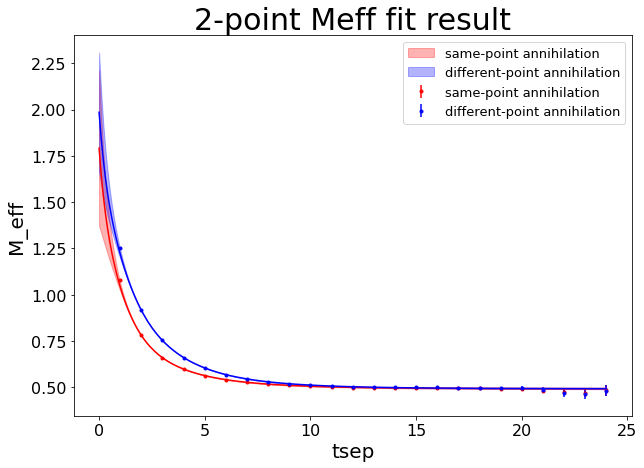

<Figure size 432x288 with 0 Axes>

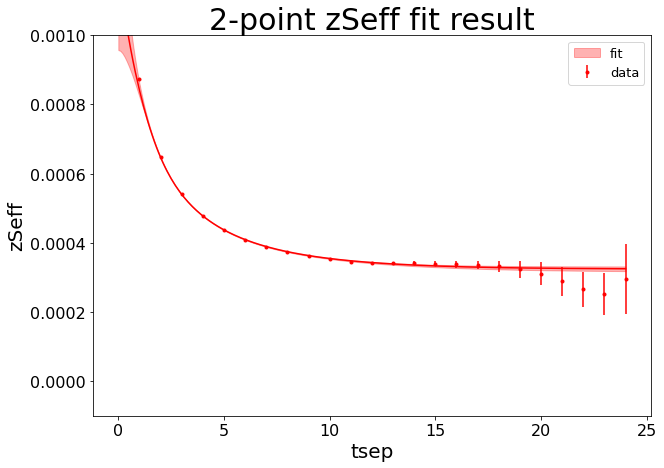

<Figure size 432x288 with 0 Axes>

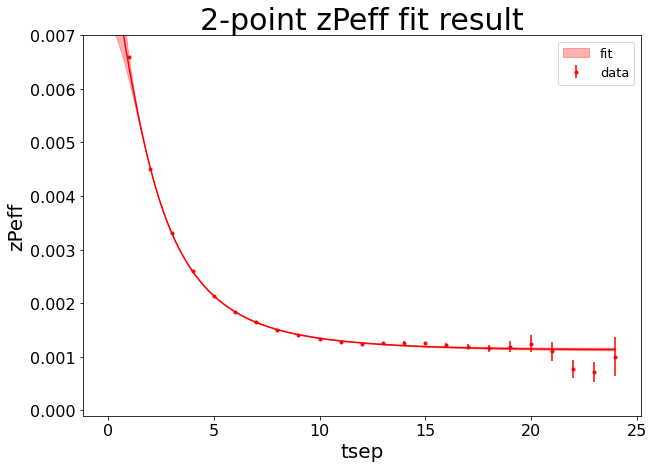

<Figure size 432x288 with 0 Axes>

In [111]:
fitcurvedata(fit_2pt)
file_format_string = "2pt_fit_{0}_nFH_{1}".format(num_zs, num_states_FH)

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], filename='{}_meff.png'.format(file_format_string))
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.001], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit", filename='{}_zSeff.png'.format(file_format_string))
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.007], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit", filename='{}_zPeff.png'.format(file_format_string))



### 2pt-3pt fits

In [112]:
# Chained
fit_2pt = lsqfit.nonlinear_fit(data=(x_2pt, y_2pt), prior=prior,fcn=all_at_once_dict,debug=True, maxit=10000)
fit_2pt3ptchained_tau1 = lsqfit.nonlinear_fit(data=(x_tau1_3pt, y_tau1_3pt), prior=fit_2pt.p,fcn=all_at_once_dict,debug=True, maxit=10000)

current_posterior = open('chained_2pt_3pt_tau1_fit_{0}_nFH_{1}.obj'.format(num_zs, num_states_FH), 'wb')
pickle.dump(fit_2pt3ptchained_tau1.p, current_posterior)
current_posterior.close()


print("2pt-3pt chained fit, tau 1: ")
print(fit_2pt.format(100))
print(fit_2pt3ptchained_tau1.format(100))

2pt-3pt chained fit, tau 1: 
Least Square Fit:
  chi2/dof [dof] = 0.85 [26]    Q = 0.69    logGBF = 617.73

Parameters:
             E0      0.4921 (29)       [    0.500 (20) ]  
             Z0   0.0003241 (76)       [ 0.000330 (30) ]  
        Ztilde0    0.001130 (30)       [  0.00120 (20) ]  
             Z1    0.000315 (43)       [  0.00050 (50) ]  
        Ztilde1     0.00159 (34)       [   0.0040 (40) ]  
             Z2    0.000473 (30)       [  0.00050 (50) ]  
        Ztilde2     0.00384 (23)       [   0.0040 (40) ]  
       log(dE1)       -1.22 (19)       [    -1.27 (70) ]  
       log(dE2)      -0.873 (92)       [    -0.17 (70) ]  *
       log(dE3)      -0.040 (93)       [     0.34 (70) ]  
             Z3    0.000774 (47)       [  0.00050 (50) ]  
        Ztilde3     0.00616 (44)       [   0.0040 (40) ]  
       log(dE4)        0.62 (69)       [     0.68 (70) ]  
             Z4     0.00047 (49)       [  0.00050 (50) ]  
        Ztilde4      0.0044 (39)       [   0.0040 (40

<ipython-input-12-41fa810c4da1>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
<ipython-input-109-a806c46fe62f>:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
<ipython-input-109-a806c46fe62f>:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

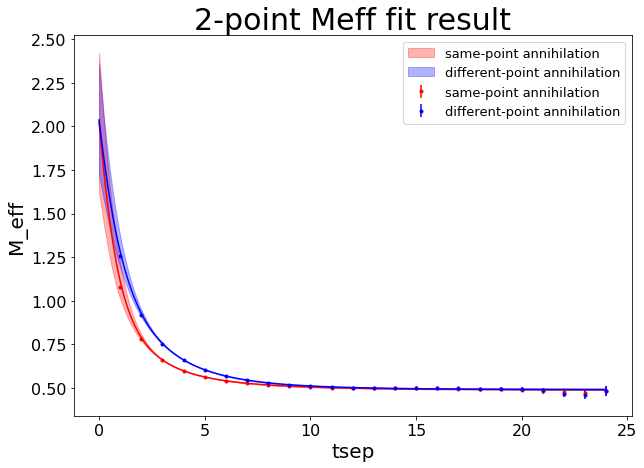

<Figure size 432x288 with 0 Axes>

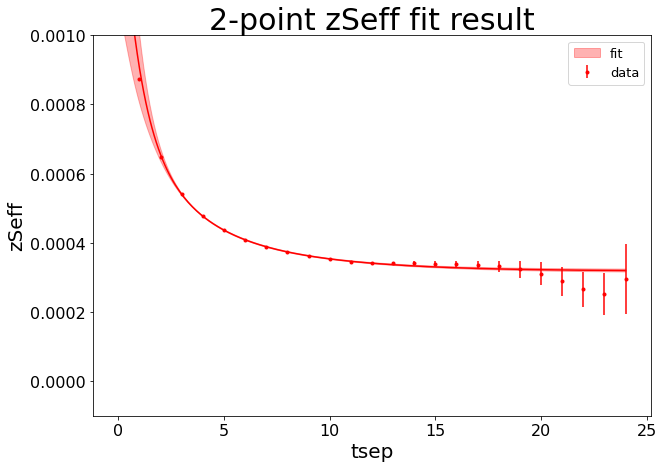

<Figure size 432x288 with 0 Axes>

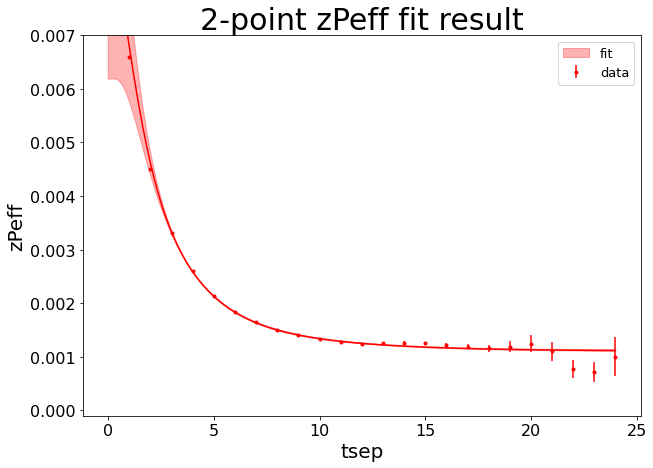

(13,)
(13,)


<Figure size 432x288 with 0 Axes>

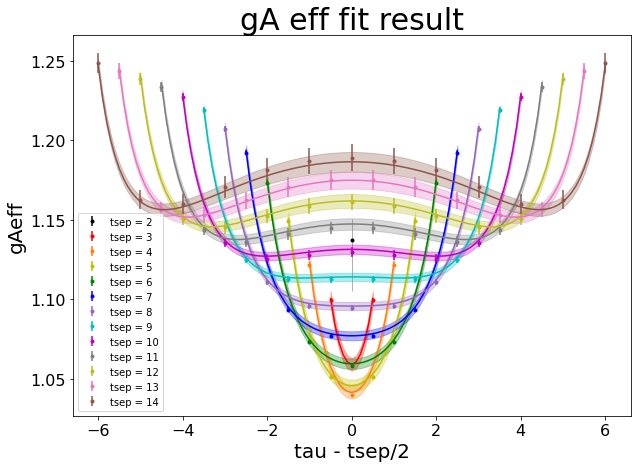

<Figure size 432x288 with 0 Axes>

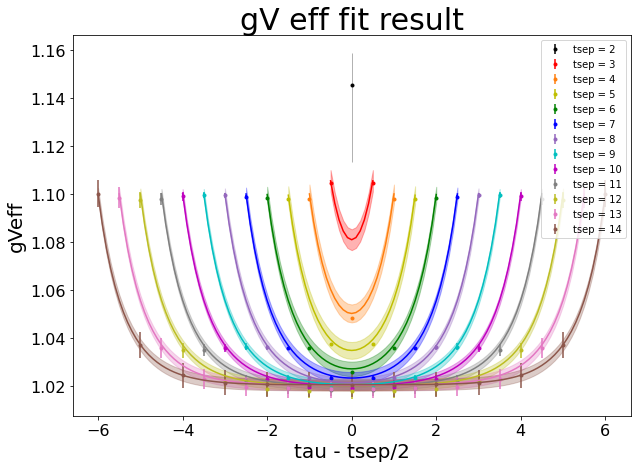

<Figure size 432x288 with 0 Axes>

In [113]:
fitcurvedata(fit_2pt3ptchained_tau1)
g00A3_fitres = fit_2pt3ptchained_tau1.p['gA3_00']
g00V4_fitres = fit_2pt3ptchained_tau1.p['gV4_00']
file_format_string = "chained_2pt_3pt_tau1_{0}_nFH_{1}".format(num_zs, num_states_FH)

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], filename='{}_meff.png'.format(file_format_string))
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.001], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit", filename='{}_zSeff.png'.format(file_format_string))
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.007], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit", filename='{}_zPeff.png'.format(file_format_string))
print(np.shape(x_3pt_data)) 
print(np.shape(y_3pt_A3))
h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt, filename='{}_gA.png'.format(file_format_string)) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt, filename='{}_gV.png'.format(file_format_string)) 


In [114]:
# simultaneous
fit_2pt3ptsimul_tau1 = lsqfit.nonlinear_fit(data=(x_tau1_2pt3pt, y_tau1_2pt3pt), prior=prior,fcn=all_at_once_dict,debug=True, maxit=10000)

print("2pt-3pt simultaneous fit, tau 1: ")
print(fit_2pt3ptsimul_tau1.format(100))


current_posterior = open('simultaneous_2pt_3pt_tau1_fit_{0}_nFH_{1}.obj'.format(num_zs, num_states_FH), 'wb')
pickle.dump(fit_2pt3ptsimul_tau1.p, current_posterior)
current_posterior.close()


2pt-3pt simultaneous fit, tau 1: 
Least Square Fit:
  chi2/dof [dof] = 0.39 [208]    Q = 1    logGBF = 6396.2

Parameters:
             E0      0.4886 (27)       [    0.500 (20) ]  
             Z0   0.0003146 (74)       [ 0.000330 (30) ]  
        Ztilde0    0.001093 (28)       [  0.00120 (20) ]  
             Z1    0.000286 (36)       [  0.00050 (50) ]  
        Ztilde1     0.00132 (24)       [   0.0040 (40) ]  
             Z2    0.000422 (38)       [  0.00050 (50) ]  
        Ztilde2     0.00332 (40)       [   0.0040 (40) ]  
       log(dE1)       -1.42 (18)       [    -1.27 (70) ]  
       log(dE2)       -0.97 (12)       [    -0.17 (70) ]  *
       log(dE3)       -0.48 (22)       [     0.34 (70) ]  *
             Z3    0.000576 (75)       [  0.00050 (50) ]  
        Ztilde3     0.00454 (70)       [   0.0040 (40) ]  
       log(dE4)        0.18 (31)       [     0.68 (70) ]  
             Z4     0.00081 (17)       [  0.00050 (50) ]  
        Ztilde4      0.0068 (14)       [   0.0040

<ipython-input-12-41fa810c4da1>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
<ipython-input-109-a806c46fe62f>:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
<ipython-input-109-a806c46fe62f>:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

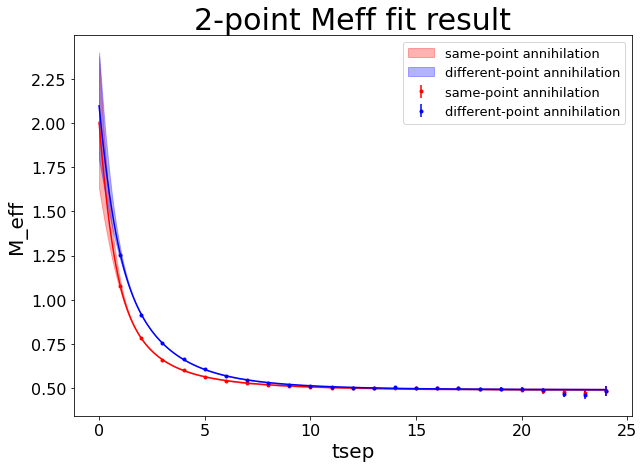

<Figure size 432x288 with 0 Axes>

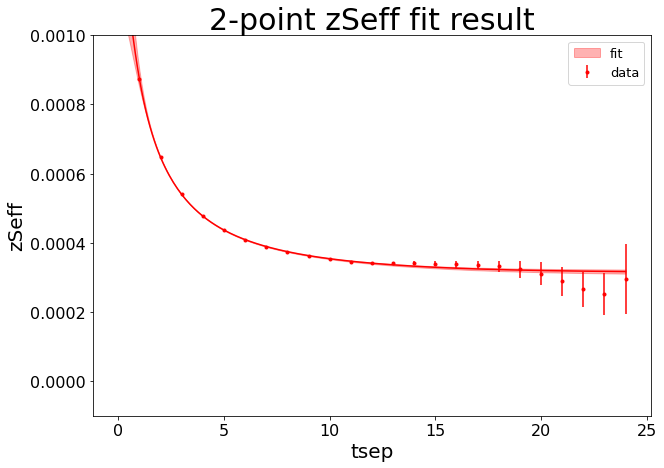

<Figure size 432x288 with 0 Axes>

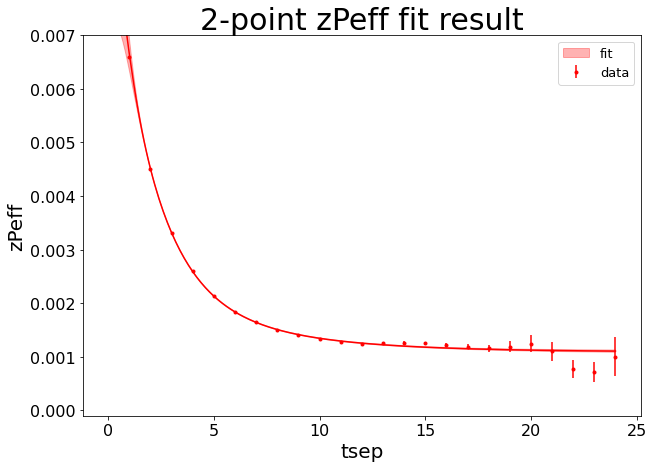

<Figure size 432x288 with 0 Axes>

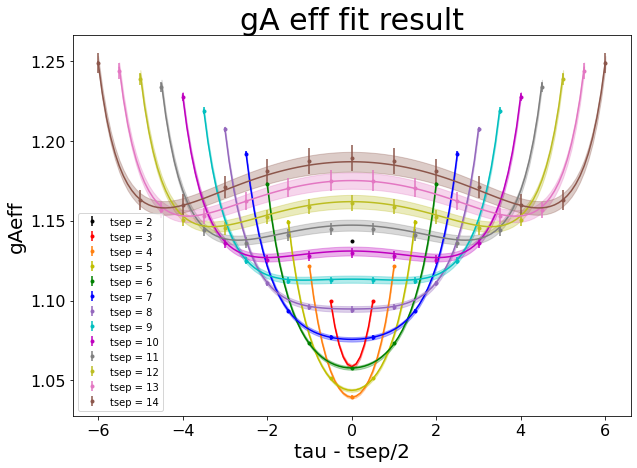

<Figure size 432x288 with 0 Axes>

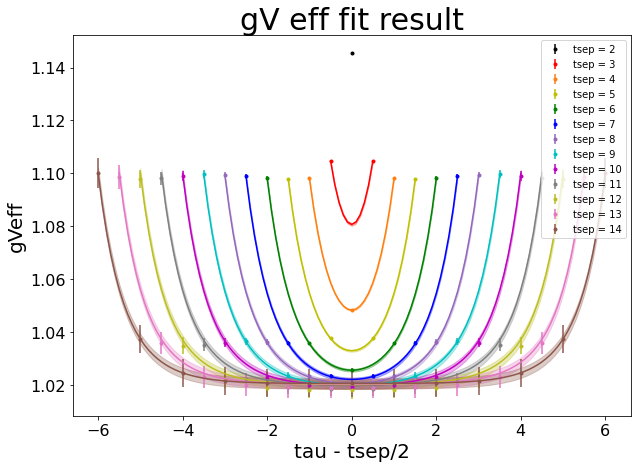

<Figure size 432x288 with 0 Axes>

In [115]:
# 2pt-3pt, simultaneous, tau1
fitcurvedata(fit_2pt3ptsimul_tau1)
g00A3_fitres = fit_2pt3ptsimul_tau1.p['gA3_00']
g00V4_fitres = fit_2pt3ptsimul_tau1.p['gV4_00']
file_format_string = "simultaneous_2pt_3pt_tau1_{0}_nFH_{1}".format(num_zs, num_states_FH)

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], filename='{}_meff.png'.format(file_format_string))
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.001], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit", filename='{}_zSeff.png'.format(file_format_string))
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.007], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit", filename='{}_zPeff.png'.format(file_format_string))

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt, filename='{}_gA.png'.format(file_format_string)) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt, filename='{}_gV.png'.format(file_format_string)) 



### 2pt-3pt-sumsub

In [116]:
# Chained
fit_2pt = lsqfit.nonlinear_fit(data=(x_2pt, y_2pt), prior=prior,fcn=all_at_once_dict,debug=True, maxit=10000)
fit_2pt3ptchained_tau1 = lsqfit.nonlinear_fit(data=(x_tau1_3pt, y_tau1_3pt), prior=fit_2pt.p,fcn=all_at_once_dict,debug=True, maxit=10000)

fit_2pt3ptsumsubchained_tau1 = lsqfit.nonlinear_fit(data=(x_tau1_3pt, y_tau1_3pt), prior=fit_2pt3ptchained_tau1.p,fcn=all_at_once_dict,debug=True, maxit=10000)


current_posterior = open('chained_2pt_3pt_sumsub_tau1_fit_{0}_nFH_{1}.obj'.format(num_zs, num_states_FH), 'wb')
pickle.dump(fit_2pt3ptsumsubchained_tau1.p, current_posterior)
current_posterior.close()


print("2pt-3pt-sumsub chained fit, tau 1: ")
print(fit_2pt.format(100))
print(fit_2pt3ptchained_tau1.format(100))
print(fit_2pt3ptsumsubchained_tau1.format(100))

2pt-3pt-sumsub chained fit, tau 1: 
Least Square Fit:
  chi2/dof [dof] = 0.85 [26]    Q = 0.69    logGBF = 617.73

Parameters:
             E0      0.4921 (29)       [    0.500 (20) ]  
             Z0   0.0003241 (76)       [ 0.000330 (30) ]  
        Ztilde0    0.001130 (30)       [  0.00120 (20) ]  
             Z1    0.000315 (43)       [  0.00050 (50) ]  
        Ztilde1     0.00159 (34)       [   0.0040 (40) ]  
             Z2    0.000473 (30)       [  0.00050 (50) ]  
        Ztilde2     0.00384 (23)       [   0.0040 (40) ]  
       log(dE1)       -1.22 (19)       [    -1.27 (70) ]  
       log(dE2)      -0.873 (92)       [    -0.17 (70) ]  *
       log(dE3)      -0.040 (93)       [     0.34 (70) ]  
             Z3    0.000774 (47)       [  0.00050 (50) ]  
        Ztilde3     0.00616 (44)       [   0.0040 (40) ]  
       log(dE4)        0.62 (69)       [     0.68 (70) ]  
             Z4     0.00047 (49)       [  0.00050 (50) ]  
        Ztilde4      0.0044 (39)       [   0.0

Least Square Fit:
  chi2/dof [dof] = 0.31 [182]    Q = 1    logGBF = 5967.2

Parameters:
             E0     0.49024 (74)       [    0.4899 (20) ]  
             Z0   0.0003192 (11)       [ 0.0003184 (48) ]  
        Ztilde0   0.0011115 (43)       [  0.001108 (19) ]  
             Z1   0.0002958 (14)       [  0.000296 (26) ]  
        Ztilde1    0.001413 (15)       [   0.00140 (21) ]  
             Z2   0.0004596 (38)       [  0.000455 (23) ]  
        Ztilde2    0.003662 (40)       [   0.00364 (20) ]  
       log(dE1)     -1.3223 (80)       [     -1.33 (11) ]  
       log(dE2)      -0.917 (13)       [    -0.924 (82) ]  
       log(dE3)      -0.142 (16)       [    -0.151 (73) ]  
             Z3   0.0007141 (71)       [  0.000712 (38) ]  
        Ztilde3     0.00565 (14)       [   0.00563 (35) ]  
       log(dE4)      -0.164 (32)       [     -0.15 (55) ]  
             Z4    0.000577 (62)       [   0.00061 (42) ]  
        Ztilde4      0.0051 (34)       [    0.0051 (38) ]  
       log(

<ipython-input-12-41fa810c4da1>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
<ipython-input-109-a806c46fe62f>:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
<ipython-input-109-a806c46fe62f>:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

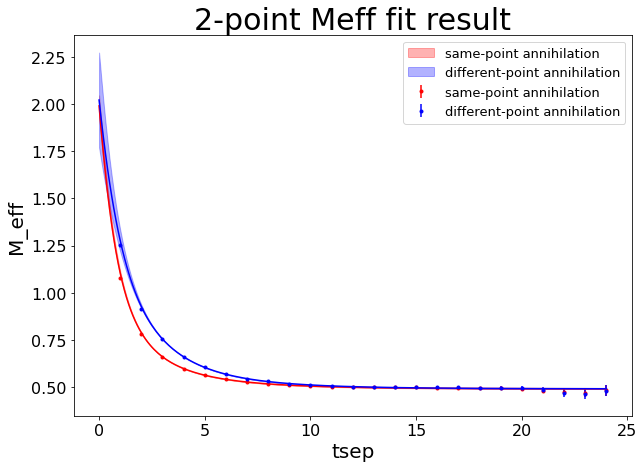

<Figure size 432x288 with 0 Axes>

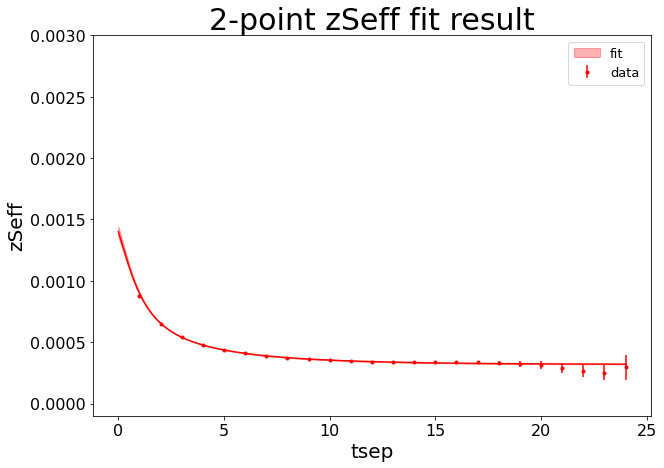

<Figure size 432x288 with 0 Axes>

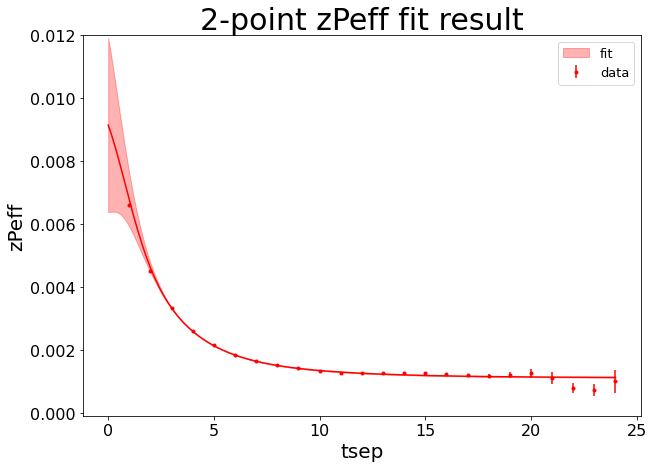

<Figure size 432x288 with 0 Axes>

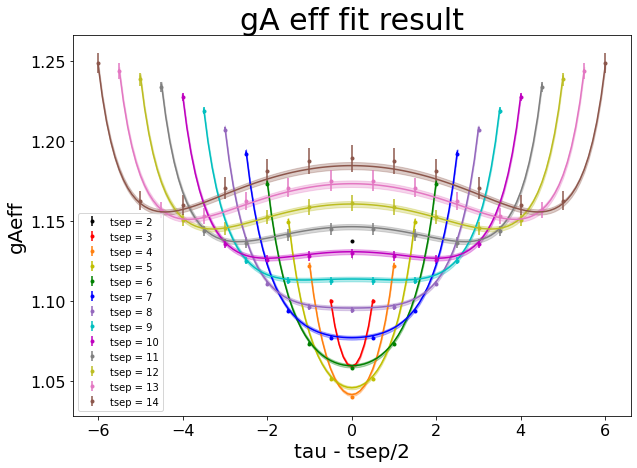

<Figure size 432x288 with 0 Axes>

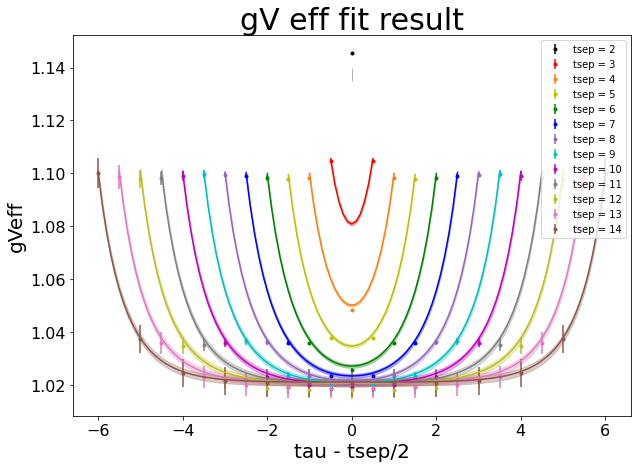

<Figure size 432x288 with 0 Axes>

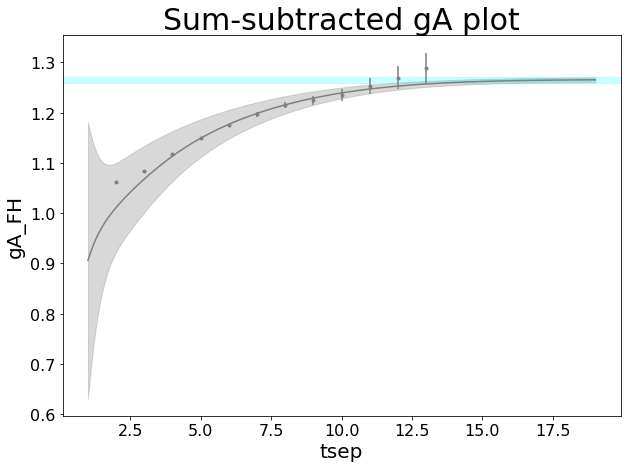

<Figure size 432x288 with 0 Axes>

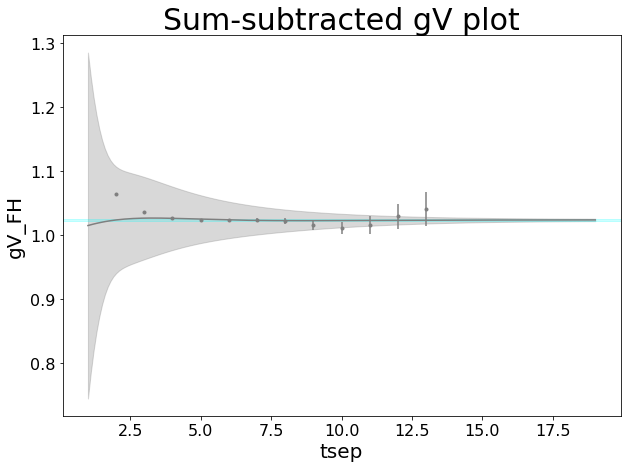

<Figure size 432x288 with 0 Axes>

In [117]:
fitcurvedata(fit_2pt3ptsumsubchained_tau1)
g00A3_fitres = fit_2pt3ptsumsubchained_tau1.p['gA3_00']
g00V4_fitres = fit_2pt3ptsumsubchained_tau1.p['gV4_00']
file_format_string = "chained_2pt_3pt_sumsub_{0}_nFH_{1}".format(num_zs, num_states_FH)

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], filename='{}_meff.png'.format(file_format_string))
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit", filename='{}_zSeff.png'.format(file_format_string))
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit", filename='{}_zPeff.png'.format(file_format_string))

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt, filename='{}_gA.png'.format(file_format_string)) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt, filename='{}_gV.png'.format(file_format_string)) 

h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH_data, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = g00A3_fitres, ydat_error=y_CFH_A3_err, filename='{}_sumsub_gA.png'.format(file_format_string)) 
h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH_data, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = g00V4_fitres, ydat_error=y_CFH_V4_err, filename='{}_sumsub_gV.png'.format(file_format_string))




In [118]:
params_chained = fit_2pt3ptsumsubchained_tau1.p
p0_vals = gv.BufferDict()
for key in params_chained.keys():
    p0_vals[key] = params_chained[key].mean

### 2pt-sumsub-3pt

In [119]:
#chained 
fit_2pt = lsqfit.nonlinear_fit(data=(x_2pt, y_2pt), prior=prior,fcn=all_at_once_dict,debug=True, maxit=10000)#, p0 = p0_vals)
fit_2ptsumsubchained = lsqfit.nonlinear_fit(data=(x_sumsub, y_sumsub), prior=fit_2pt.p,fcn=all_at_once_dict,debug=True, maxit=10000)#, p0 = p0_vals)
fit_2ptsumsub3ptchained = lsqfit.nonlinear_fit(data=(x_tau1_3pt, y_tau1_3pt), prior=fit_2ptsumsubchained.p,fcn=all_at_once_dict,debug=True, maxit=10000)#, p0 = p0_vals)



print("2pt-sumsub-3pt chained fit: ")
print(fit_2pt.format(100))
print(fit_2ptsumsubchained.format(100))
print(fit_2ptsumsub3ptchained.format(100))


current_posterior = open('chained_2pt_sumsub_3pt_fit_{0}_nFH_{1}.obj'.format(num_zs, num_states_FH), 'wb')
pickle.dump(fit_2ptsumsub3ptchained.p, current_posterior)
current_posterior.close()

2pt-sumsub-3pt chained fit: 
Least Square Fit:
  chi2/dof [dof] = 0.85 [26]    Q = 0.69    logGBF = 617.73

Parameters:
             E0      0.4921 (29)       [    0.500 (20) ]  
             Z0   0.0003241 (76)       [ 0.000330 (30) ]  
        Ztilde0    0.001130 (30)       [  0.00120 (20) ]  
             Z1    0.000315 (43)       [  0.00050 (50) ]  
        Ztilde1     0.00159 (34)       [   0.0040 (40) ]  
             Z2    0.000473 (30)       [  0.00050 (50) ]  
        Ztilde2     0.00384 (23)       [   0.0040 (40) ]  
       log(dE1)       -1.22 (19)       [    -1.27 (70) ]  
       log(dE2)      -0.873 (92)       [    -0.17 (70) ]  *
       log(dE3)      -0.040 (93)       [     0.34 (70) ]  
             Z3    0.000774 (47)       [  0.00050 (50) ]  
        Ztilde3     0.00616 (44)       [   0.0040 (40) ]  
       log(dE4)        0.62 (69)       [     0.68 (70) ]  
             Z4     0.00047 (49)       [  0.00050 (50) ]  
        Ztilde4      0.0044 (39)       [   0.0040 (40

<ipython-input-12-41fa810c4da1>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
<ipython-input-109-a806c46fe62f>:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
<ipython-input-109-a806c46fe62f>:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

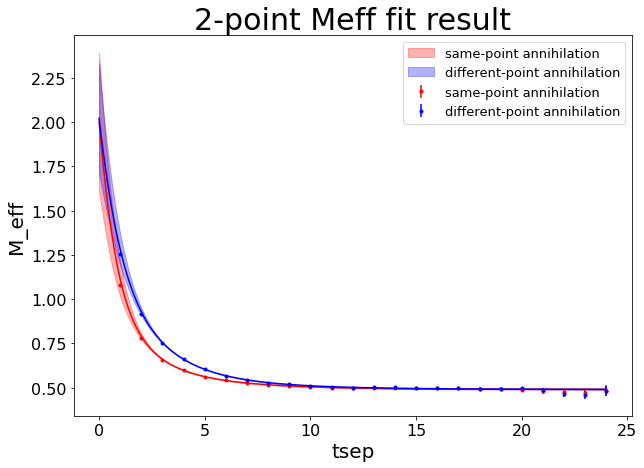

<Figure size 432x288 with 0 Axes>

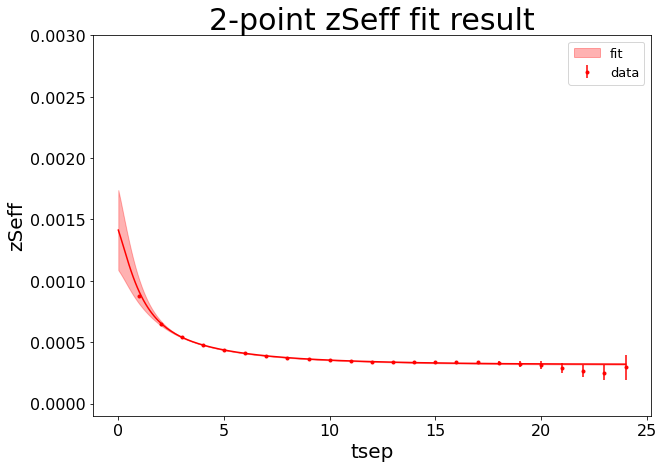

<Figure size 432x288 with 0 Axes>

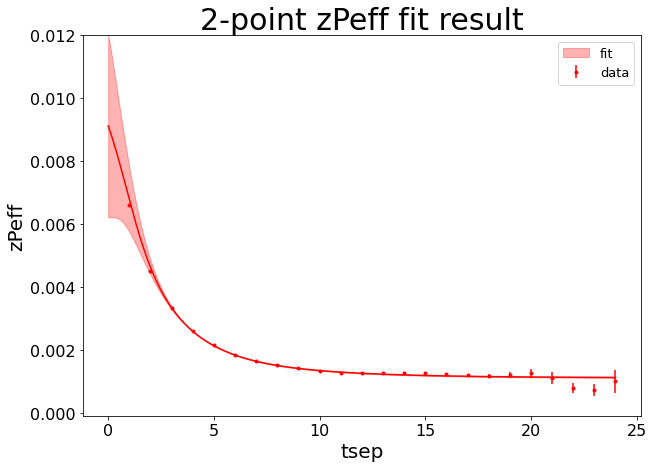

<Figure size 432x288 with 0 Axes>

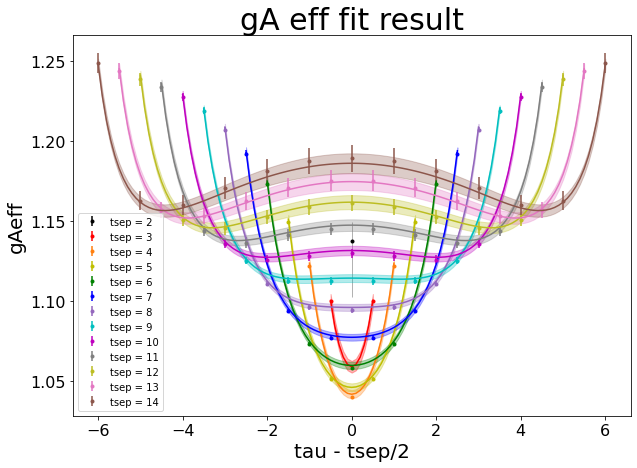

<Figure size 432x288 with 0 Axes>

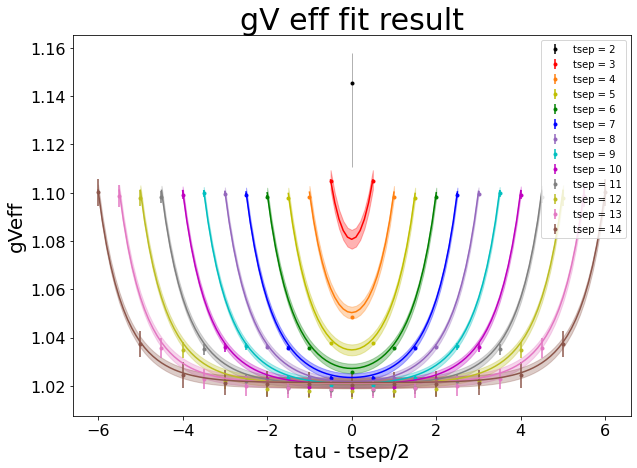

<Figure size 432x288 with 0 Axes>

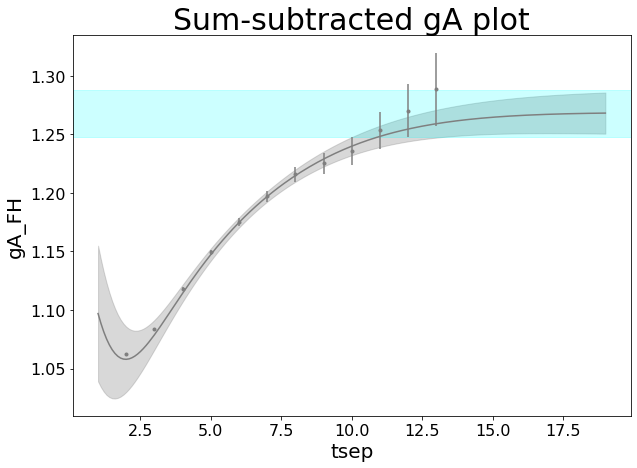

<Figure size 432x288 with 0 Axes>

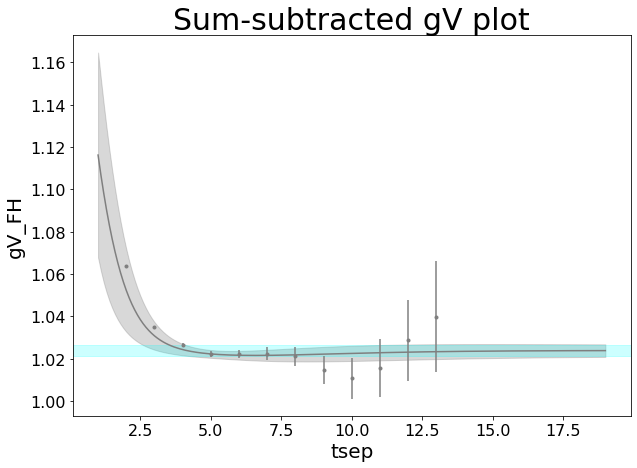

<Figure size 432x288 with 0 Axes>

In [120]:
fitcurvedata(fit_2ptsumsub3ptchained)
g00A3_fitres = fit_2ptsumsub3ptchained.p['gA3_00']
g00V4_fitres = fit_2ptsumsub3ptchained.p['gV4_00']
file_format_string = "chained_2pt_sumsub_3pt_{0}_nFH_{1}".format(num_zs, num_states_FH)

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], filename='{}_meff.png'.format(file_format_string))
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit", filename='{}_zSeff.png'.format(file_format_string))
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit", filename='{}_zPeff.png'.format(file_format_string))

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt, filename='{}_gA.png'.format(file_format_string)) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt, filename='{}_gV.png'.format(file_format_string)) 

h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH_data, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = g00A3_fitres, ydat_error=y_CFH_A3_err, filename='{}_sumsub_gA.png'.format(file_format_string)) 
h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH_data, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = g00V4_fitres, ydat_error=y_CFH_V4_err, filename='{}_sumsub_gV.png'.format(file_format_string))



In [121]:
params_chained = fit_2ptsumsub3ptchained.p #fit_2pt3ptchained_tau1 #fit_2pt3ptsimul_tau1.p
p0_vals = gv.BufferDict()
for key in params_chained.keys():
    p0_vals[key] = params_chained[key].mean


In [122]:
#simultaneous

fit_2ptsumsub3ptsimul = lsqfit.nonlinear_fit(data=(x_tau1_2pt3ptsumsub, y_tau1_2pt3ptsumsub), prior=prior,fcn=all_at_once_dict,debug=True, maxit=10000, p0 = p0_vals)

print("2pt-sumsub-3pt simultaneous fit: ")
print(fit_2ptsumsub3ptsimul.format(100))


current_posterior = open('simultaneous_2pt_sumsub_3pt_fit_{0}_nFH_{1}.obj'.format(num_zs, num_states_FH), 'wb')
pickle.dump(fit_2ptsumsub3ptsimul.p, current_posterior)
current_posterior.close()

2pt-sumsub-3pt simultaneous fit: 
Least Square Fit:
  chi2/dof [dof] = 0.47 [232]    Q = 1    logGBF = 6567.2

Parameters:
             E0     0.48985 (95)       [    0.500 (20) ]  
             Z0   0.0003195 (28)       [ 0.000330 (30) ]  
        Ztilde0    0.001113 (11)       [  0.00120 (20) ]  
             Z1    0.000271 (25)       [  0.00050 (50) ]  
        Ztilde1     0.00128 (17)       [   0.0040 (40) ]  
             Z2    0.000399 (39)       [  0.00050 (50) ]  
        Ztilde2     0.00290 (28)       [   0.0040 (40) ]  
       log(dE1)       -1.36 (11)       [    -1.27 (70) ]  
       log(dE2)       -1.15 (11)       [    -0.17 (70) ]  *
       log(dE3)       -0.68 (22)       [     0.34 (70) ]  *
             Z3    0.000479 (54)       [  0.00050 (50) ]  
        Ztilde3     0.00414 (46)       [   0.0040 (40) ]  
       log(dE4)       -0.06 (12)       [     0.68 (70) ]  *
             Z4    0.000778 (44)       [  0.00050 (50) ]  
        Ztilde4     0.00604 (48)       [   0.004

<ipython-input-12-41fa810c4da1>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
<ipython-input-109-a806c46fe62f>:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
<ipython-input-109-a806c46fe62f>:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

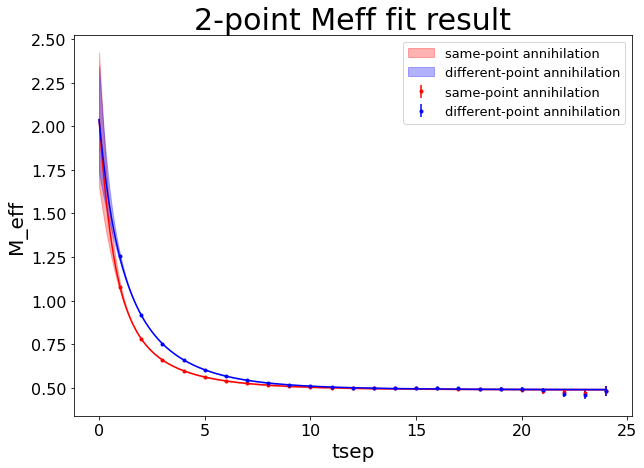

<Figure size 432x288 with 0 Axes>

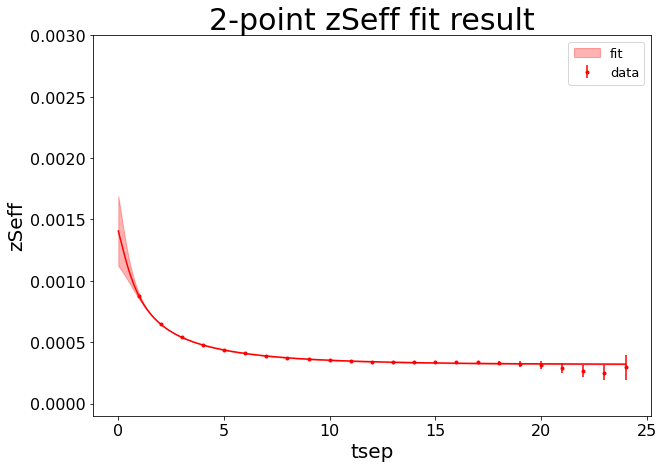

<Figure size 432x288 with 0 Axes>

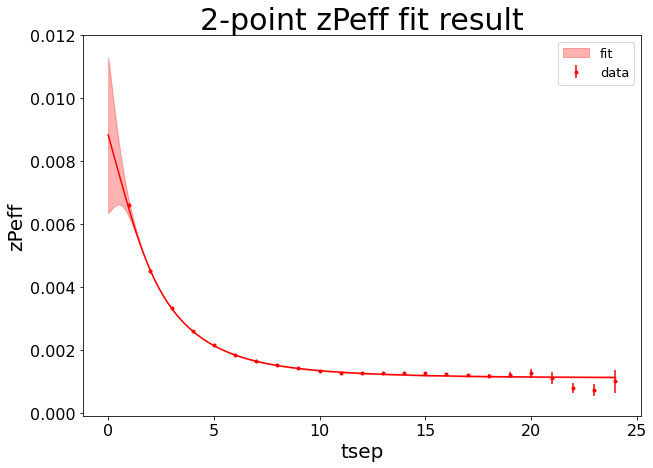

<Figure size 432x288 with 0 Axes>

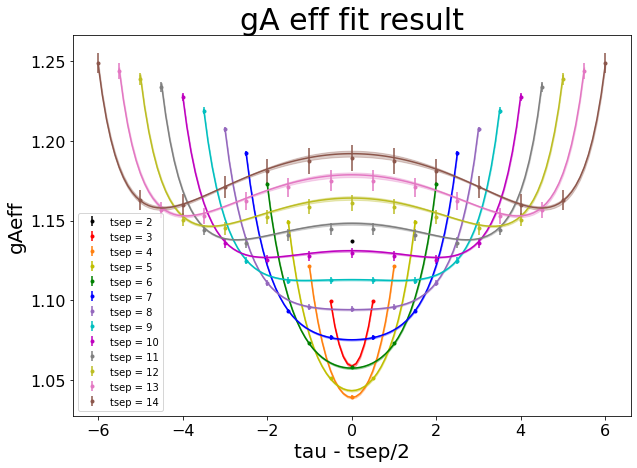

<Figure size 432x288 with 0 Axes>

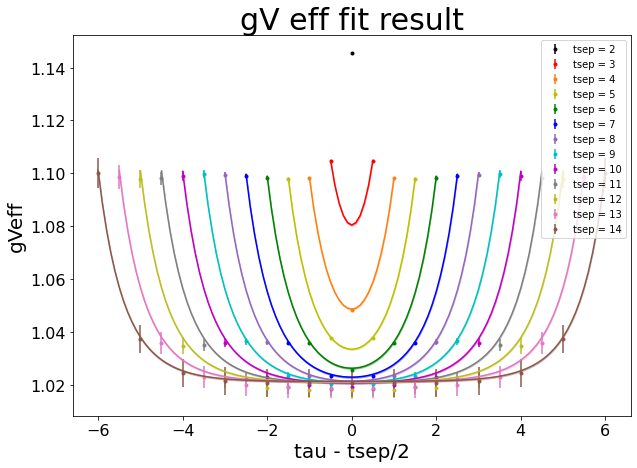

<Figure size 432x288 with 0 Axes>

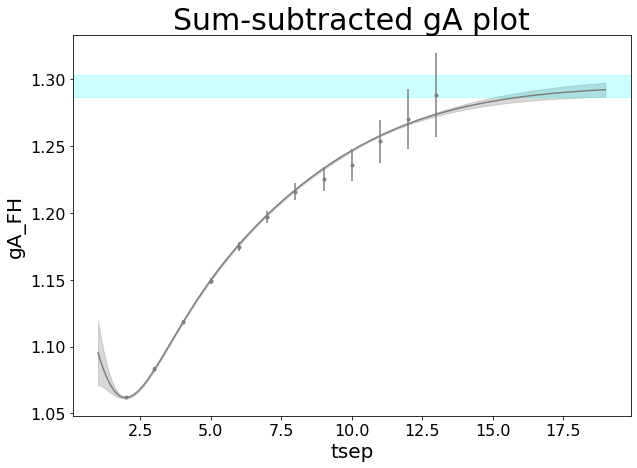

<Figure size 432x288 with 0 Axes>

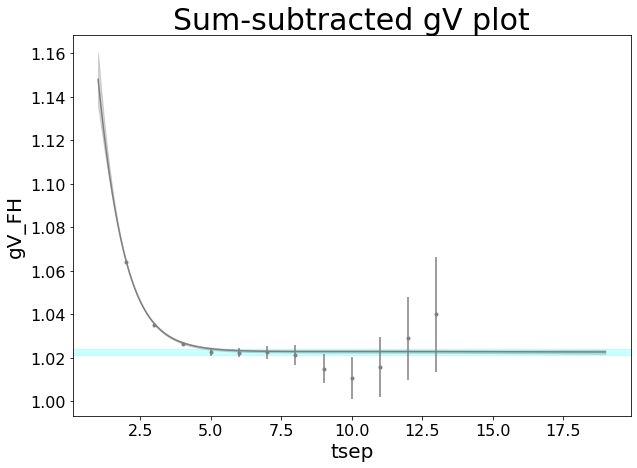

<Figure size 432x288 with 0 Axes>

In [123]:
fitcurvedata(fit_2ptsumsub3ptsimul)
g00A3_fitres = fit_2ptsumsub3ptsimul.p['gA3_00']
g00V4_fitres = fit_2ptsumsub3ptsimul.p['gV4_00']
file_format_string = "simultaneous_2pt_sumsub_3pt_{0}_nFH_{1}".format(num_zs, num_states_FH)

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], filename='{}_meff.png'.format(file_format_string))
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit", filename='{}_zSeff.png'.format(file_format_string))
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit", filename='{}_zPeff.png'.format(file_format_string))

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt, filename='{}_gA.png'.format(file_format_string)) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt, filename='{}_gV.png'.format(file_format_string)) 

h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH_data, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = g00A3_fitres, ydat_error=y_CFH_A3_err, filename='{}_sumsub_gA.png'.format(file_format_string)) 
h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH_data, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = g00V4_fitres, ydat_error=y_CFH_V4_err, filename='{}_sumsub_gV.png'.format(file_format_string))




### 2pt-sumsub

In [124]:
#num_zs = 5
#chained 
fit_2pt = lsqfit.nonlinear_fit(data=(x_2pt, y_2pt), prior=prior,fcn=all_at_once_dict,debug=True, maxit=10000)

fit_2ptsumsubchained = lsqfit.nonlinear_fit(data=(x_sumsub, y_sumsub), prior=fit_2pt.p,fcn=all_at_once_dict,debug=True, maxit=10000)


print("2pt-sumsub chained fit: ")
print(fit_2pt.format(100))
print(fit_2ptsumsubchained.format(100))


current_posterior = open('chained_2pt_sumsub_fit_{0}_nFH_{1}.obj'.format(num_zs, num_states_FH), 'wb')
pickle.dump(fit_2ptsumsubchained.p, current_posterior)
current_posterior.close()

2pt-sumsub chained fit: 
Least Square Fit:
  chi2/dof [dof] = 0.85 [26]    Q = 0.69    logGBF = 617.73

Parameters:
             E0      0.4921 (29)       [    0.500 (20) ]  
             Z0   0.0003241 (76)       [ 0.000330 (30) ]  
        Ztilde0    0.001130 (30)       [  0.00120 (20) ]  
             Z1    0.000315 (43)       [  0.00050 (50) ]  
        Ztilde1     0.00159 (34)       [   0.0040 (40) ]  
             Z2    0.000473 (30)       [  0.00050 (50) ]  
        Ztilde2     0.00384 (23)       [   0.0040 (40) ]  
       log(dE1)       -1.22 (19)       [    -1.27 (70) ]  
       log(dE2)      -0.873 (92)       [    -0.17 (70) ]  *
       log(dE3)      -0.040 (93)       [     0.34 (70) ]  
             Z3    0.000774 (47)       [  0.00050 (50) ]  
        Ztilde3     0.00616 (44)       [   0.0040 (40) ]  
       log(dE4)        0.62 (69)       [     0.68 (70) ]  
             Z4     0.00047 (49)       [  0.00050 (50) ]  
        Ztilde4      0.0044 (39)       [   0.0040 (40) ] 

<ipython-input-12-41fa810c4da1>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
<ipython-input-109-a806c46fe62f>:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
<ipython-input-109-a806c46fe62f>:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

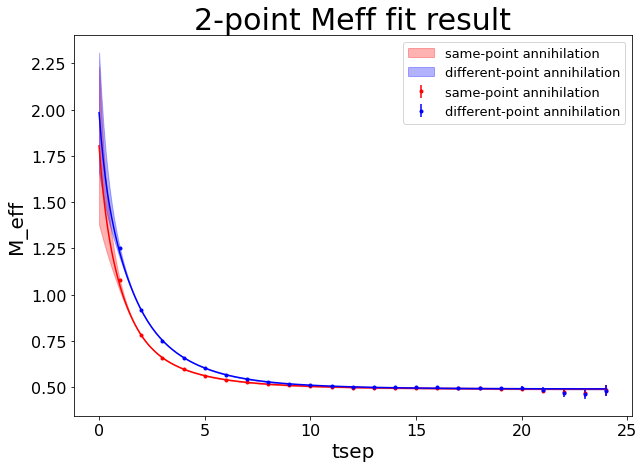

<Figure size 432x288 with 0 Axes>

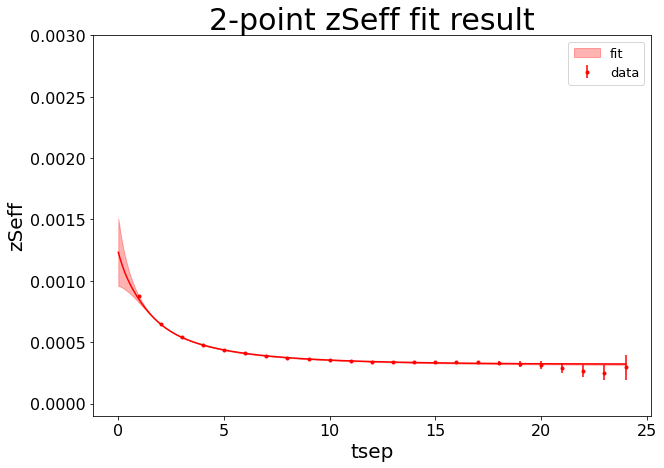

<Figure size 432x288 with 0 Axes>

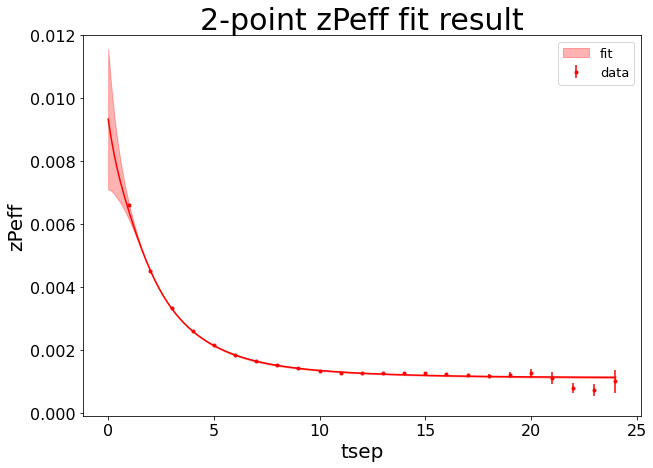

<Figure size 432x288 with 0 Axes>

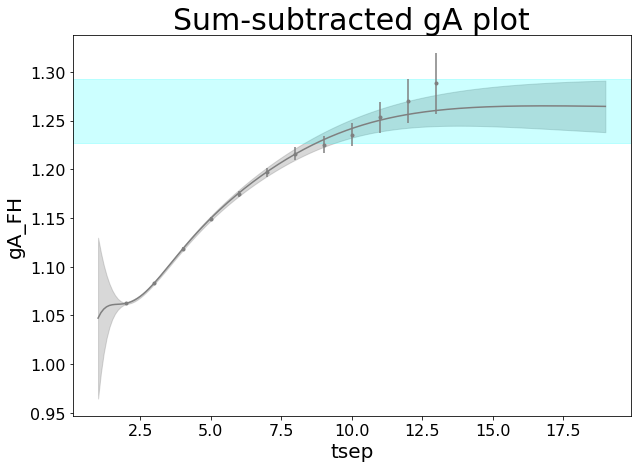

<Figure size 432x288 with 0 Axes>

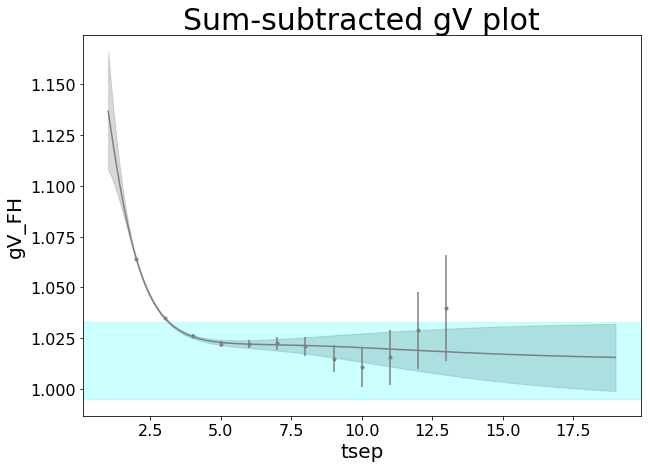

<Figure size 432x288 with 0 Axes>

In [125]:
fitcurvedata(fit_2ptsumsubchained)
g00A3_fitres = fit_2ptsumsubchained.p['gA3_00']
g00V4_fitres = fit_2ptsumsubchained.p['gV4_00']
file_format_string = "chained_2pt_sumsub_{0}_nFH_{1}".format(num_zs, num_states_FH)

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], filename='{}_meff.png'.format(file_format_string))
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit", filename='{}_zSeff.png'.format(file_format_string))
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit", filename='{}_zPeff.png'.format(file_format_string))

h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH_data, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = g00A3_fitres, ydat_error=y_CFH_A3_err, filename='{}_sumsub_gA.png'.format(file_format_string)) 
h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH_data, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = g00V4_fitres, ydat_error=y_CFH_V4_err, filename='{}_sumsub_gV.png'.format(file_format_string))



In [126]:
#simultaneous
fit_2ptsumsubsimul = lsqfit.nonlinear_fit(data=(x_tau1_2ptsumsub, y_tau1_2ptsumsub), prior=prior,fcn=all_at_once_dict,debug=True, maxit=10000)

print("2pt-sumsub simultaneous fit: ")
print(fit_2ptsumsubsimul.format(100))


current_posterior = open('simultaneous_2pt_sumsub_fit_{0}_nFH_{1}.obj'.format(num_zs, num_states_FH), 'wb')
pickle.dump(fit_2ptsumsubsimul.p, current_posterior)
current_posterior.close()

2pt-sumsub simultaneous fit: 
Least Square Fit:
  chi2/dof [dof] = 0.82 [50]    Q = 0.81    logGBF = 692.77

Parameters:
             E0      0.4904 (30)       [    0.500 (20) ]  
             Z0   0.0003197 (82)       [ 0.000330 (30) ]  
        Ztilde0    0.001113 (32)       [  0.00120 (20) ]  
             Z1    0.000298 (33)       [  0.00050 (50) ]  
        Ztilde1     0.00145 (26)       [   0.0040 (40) ]  
             Z2    0.000479 (25)       [  0.00050 (50) ]  
        Ztilde2     0.00380 (20)       [   0.0040 (40) ]  
       log(dE1)       -1.32 (19)       [    -1.27 (70) ]  
       log(dE2)      -0.871 (80)       [    -0.17 (70) ]  *
       log(dE3)      -0.039 (88)       [     0.34 (70) ]  
             Z3    0.000769 (51)       [  0.00050 (50) ]  
        Ztilde3     0.00616 (43)       [   0.0040 (40) ]  
       log(dE4)        0.62 (69)       [     0.68 (70) ]  
             Z4     0.00050 (48)       [  0.00050 (50) ]  
        Ztilde4      0.0043 (38)       [   0.0040 (4

<ipython-input-12-41fa810c4da1>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
<ipython-input-109-a806c46fe62f>:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
<ipython-input-109-a806c46fe62f>:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

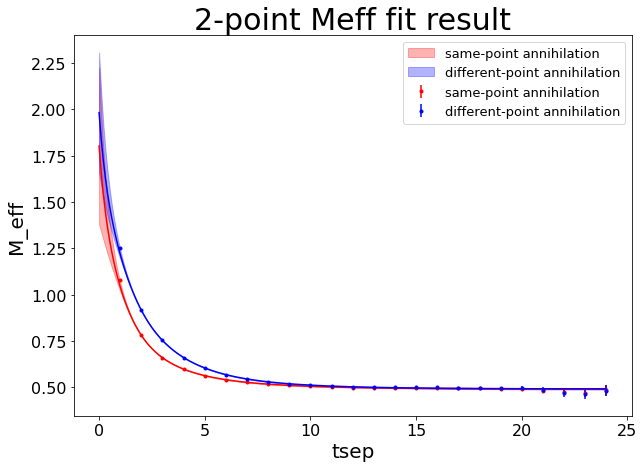

<Figure size 432x288 with 0 Axes>

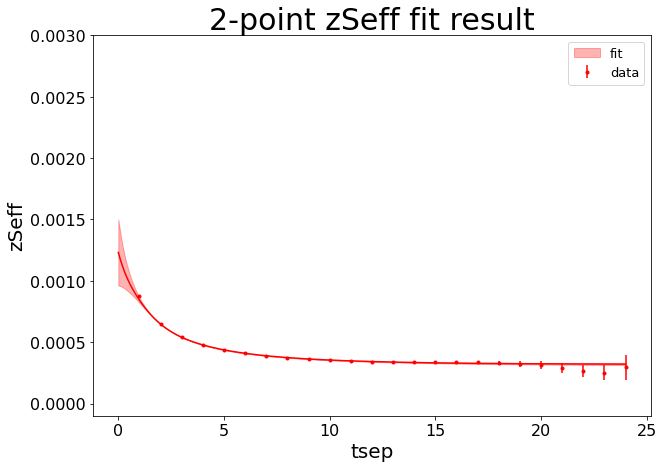

<Figure size 432x288 with 0 Axes>

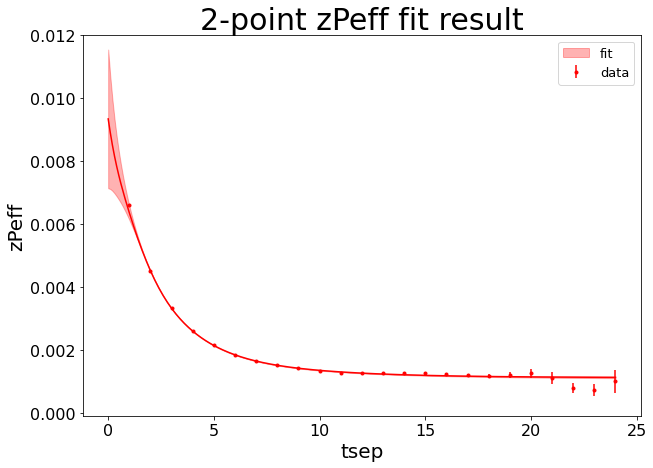

<Figure size 432x288 with 0 Axes>

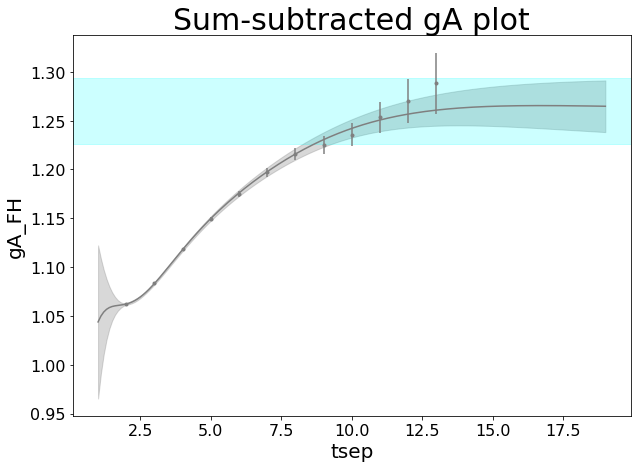

<Figure size 432x288 with 0 Axes>

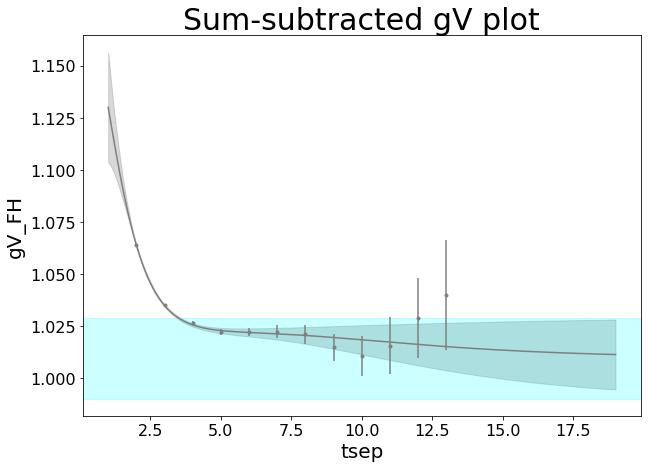

<Figure size 432x288 with 0 Axes>

In [127]:
fitcurvedata(fit_2ptsumsubsimul)
g00A3_fitres = fit_2ptsumsubsimul.p['gA3_00']
g00V4_fitres = fit_2ptsumsubsimul.p['gV4_00']
file_format_string = "simultaneous_2pt_sumsub_{0}_nFH_{1}".format(num_zs, num_states_FH)

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], filename='{}_meff.png'.format(file_format_string))
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit", filename='{}_zSeff.png'.format(file_format_string))
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit", filename='{}_zPeff.png'.format(file_format_string))

h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH_data, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = g00A3_fitres, ydat_error=y_CFH_A3_err, filename='{}_sumsub_gA.png'.format(file_format_string)) 
h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH_data, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", 30, 20, 16, 13, g00 = g00V4_fitres, ydat_error=y_CFH_V4_err, filename='{}_sumsub_gV.png'.format(file_format_string))

